In [30]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.evaluator import evaluator

import tensorflow as tf
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten, Input, Concatenate, BatchNormalization, LSTM, Bidirectional, Attention, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Descargar la lista de stopwords si no está ya descargada
nltk.download('stopwords')

# Cargar las stopwords en español
spanish_stopwords = set(stopwords.words('spanish'))


print("¿GPU disponible?:", tf.config.list_physical_devices('GPU'))

¿GPU disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/liingfeng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
train = Loader.load_NLP()

/home/liingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/NLP/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the ori

In [32]:
def custom_concat(row, cols):
    # Construir la descripción con lógica condicional basada en el valor de la celda
    parts = []
    for col_name in cols:  # Cambio para iterar solo sobre las columnas especificadas
        if col_name in row.index:  # Verificar que el nombre de la columna esté en el DataFrame
            value = row[col_name]
            if value == "no tiene" or not isinstance(value, str):
                parts.append(f"no tiene {col_name}")
            else:
                parts.append(str(value))  # Convertir a string para evitar problemas al unir
    # Unir todas las partes con espacios
    return ' '.join(parts)

# Aplicar la función al DataFrame
def filter_train_data(train):
    descriptions = [col for col in train.columns if "description" in col]
    train['full_description'] = train.apply(custom_concat, axis=1, args=(descriptions,))
    filtered_columns = ["price", "km", "fuelType", "full_description"]
    train = train[filtered_columns]
    train.dropna(inplace=True)
    return train

train = filter_train_data(train)

km_scaler = StandardScaler()
train["km"] = km_scaler.fit_transform(train["km"].to_numpy().reshape(-1, 1))

price_scaler = StandardScaler()
train["price"] = price_scaler.fit_transform(train["price"].to_numpy().reshape(-1, 1))

/tmp/ipykernel_41120/2940014903.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)


In [33]:
#Parameters
verb_size = 150

In [34]:
# Load data (assuming df is your DataFrame containing the required columns)
texts = train['full_description'].values  # descriptions
# Tokenization and sequence padding
tokenizer = Tokenizer(num_words=verb_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
data = pad_sequences(sequences,  maxlen=verb_size, padding='post')

In [35]:
train_data, test_data, train_prices, test_prices, train_km, test_km = train_test_split(
    data, train['price'], train['km'], test_size=0.2, random_state=42, stratify=train['fuelType'])

In [37]:
train_data = tf.convert_to_tensor(train_data, dtype=tf.int32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.int32)

In [38]:
train_prices = tf.convert_to_tensor(train_prices, dtype=tf.float32)
test_prices = tf.convert_to_tensor(test_prices, dtype=tf.float32)

In [39]:
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)
train_km = tf.convert_to_tensor(train_km, dtype=tf.float32)

In [40]:
# Text input branch
text_input = Input(shape=(train_data.shape[1],), dtype='int32')

# Capa de Embedding
text_embed_layer = Embedding(input_dim=train_data.shape[1], output_dim=verb_size, input_length=train_data.shape[1])
text_embed = text_embed_layer(text_input)

# Primera capa LSTM bidireccional con 'return_sequences=True' para permitir apilar más capas
lstm_out = Bidirectional(LSTM(128, return_sequences=True))(text_embed)
lstm_out = Dropout(0.5)(lstm_out)

# Segunda capa LSTM
lstm_out = LSTM(64, return_sequences=True)(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)

# Capa de Atención
attention_out = Attention()([lstm_out, lstm_out])

# Aplanamos la salida de la atención
flatten = Flatten()(attention_out)

/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [41]:
# Embedding input branch

# KM branch
input_km = Input(shape=(1,), name='km_input')
km_processed = Dense(32, activation='linear')(input_km)

# Concatenate both branches
concat = Concatenate()([flatten, km_processed])
hidden = Dense(256, activation='relu')(concat)
output = Dense(1, activation='linear')(hidden)  # Output layer for price prediction

model = Model(inputs=[text_input, input_km], outputs=output)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 150, 150)  │     22,500 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 150, 256)  │    285,696 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 150, 256)  │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 150, 64)   │     82,176 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 150, 64)   │          0 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 150, 64)   │          0 │ dropout_5[0][0],  │
│ (Attention)         │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ km_input            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 9600)      │          0 │ attention_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │         64 │ km_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 9632)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  2,466,048 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        257 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,856,741 (10.90 MB)

 Trainable params: 2,856,741 (10.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='huber', metrics=['mean_absolute_error', "mean_absolute_percentage_error"])

In [43]:
# Train the model
print("COMIENZA EL ENTRENAMIENTO...")
history = model.fit([train_data, train_km], train_prices,
          validation_data=([test_data, test_km], test_prices),
          epochs=30, batch_size=128)
print("TERMINA EL ENTRENAMIENTO...")

COMIENZA EL ENTRENAMIENTO...
Epoch 1/30


/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_24', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1030/1033 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1141 - mean_absolute_error: 0.3107 - mean_absolute_percentage_error: 170.4305

/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_24', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.1140 - mean_absolute_error: 0.3106 - mean_absolute_percentage_error: 170.3586 - val_loss: 0.0721 - val_mean_absolute_error: 0.2375 - val_mean_absolute_percentage_error: 135.3681
Epoch 2/30
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0676 - mean_absolute_error: 0.2276 - mean_absolute_percentage_error: 124.3555 - val_loss: 0.0587 - val_mean_absolute_error: 0.2090 - val_mean_absolute_percentage_error: 110.6673
Epoch 3/30
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0607 - mean_absolute_error: 0.2173 - mean_absolute_percentage_error: 124.2819 - val_loss: 0.0567 - val_mean_absolute_error: 0.2150 - val_mean_absolute_percentage_error: 131.9610
Epoch 4/30
1033/1033 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0569 - mean_absolute_error: 0.2084 - mean_absolute_percentage_error: 116.6598 - val_loss: 0.0497 - val_mean_absolute_error: 0.2013 - val_mean_absolute_percentage_error: 91.6945
Epoch 5/30
1033/1033 ━━━━━━━━━━━━━━━

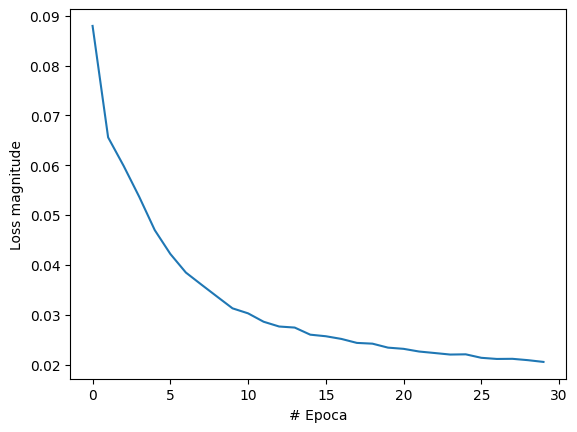

In [44]:
plt.xlabel("# Epoca")
plt.ylabel("Loss magnitude")
plt.plot(history.history["loss"])

  13/1033 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step    

/home/liingfeng/Desktop/tensorflow/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_24', 'km_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1033/1033 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
   Actual_Price  Predicted_Price        km
0        6999.0     10598.075195   84999.0
1       14290.0     15063.763672   47682.0
2       36500.0     34775.886719   73021.0
3        6995.0     10226.905273  110000.0
4        8500.0      6911.773438  247449.0
MAE: 2747.7466 
 MSE: 51743628.0 
 RMSE: 7193.304 
 R2: 0.8892644047737122 
 MAPE: 13.738483190536499
Mean: 2747.7466
Variance: 44193510.0
Standard Deviation: 6647.8203


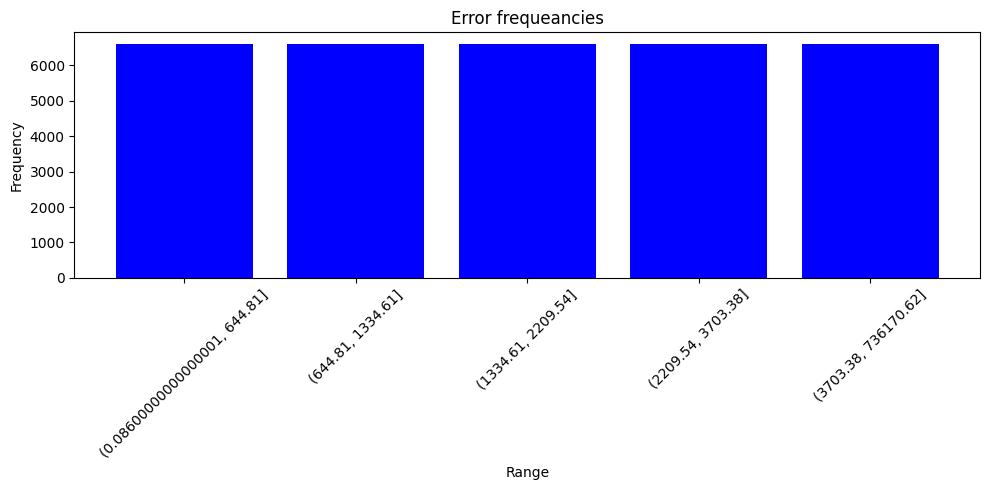

{'(0.08600000000000001, 644.81]': 6606, '(644.81, 1334.61]': 6605, '(1334.61, 2209.54]': 6606, '(2209.54, 3703.38]': 6605, '(3703.38, 736170.62]': 6606}


In [ ]:
predicted_prices = model.predict([test_data, test_km])

# Assuming test_prices is a 1D array, we can convert it to a DataFrame
results_df = pd.DataFrame({
    'Actual_Price': price_scaler.inverse_transform(np.array(test_prices).reshape(-1,1)).flatten(),
    'Predicted_Price': price_scaler.inverse_transform(predicted_prices).flatten(),  # Flatten in case it's a 2D array
    'km' : km_scaler.inverse_transform(test_km.to_numpy().reshape(-1, 1)).flatten()
})

# Display the first few rows of the DataFrame
print(results_df.head())

evaluator.eval_regression(results_df["Predicted_Price"], results_df["Actual_Price"], plot=False)